pip install SentenceTransformers (https://huggingface.co/sentence-transformers)
conda install umap-learn
conda install hdbscan
conda install bertopic
conda install nltk

In [39]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

In [76]:
def extraire_contenu_tei(chemin_fichier):
    """
    Extrait le contenu d'un fichier XML TEI et le stocke sous forme structurée.
    
    Args:
        chemin_fichier: Chemin vers le fichier XML
        
    Returns:
        Dictionnaire contenant les données structurées
    """
    # Définir l'espace de noms TEI
    ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
    
    # Parser le fichier XML
    tree = ET.parse(chemin_fichier)
    root = tree.getroot()
    
    # Dictionnaire pour stocker les données
    donnees = {
        'fichier': os.path.basename(chemin_fichier)
    }
    
    # Fonction auxiliaire pour extraire le texte en excluant les notes
    def extraire_texte_sans_notes(element):
        if element.tag.endswith('note'):
            return ""
        
        texte = element.text or ""
        for enfant in element:
            texte += extraire_texte_sans_notes(enfant)
            if enfant.tail:
                texte += enfant.tail
        return texte
    
    # 1. Métadonnées de la lettre
    try:
        # ID de la lettre
        corresp_desc = root.find('.//tei:correspDesc', ns)
        if corresp_desc is not None:
            donnees['id_lettre'] = corresp_desc.get('{http://www.w3.org/XML/1998/namespace}id')
        
        # Expéditeur
        expediteur = root.find('.//tei:correspAction[@type="write"]/tei:persName', ns)
        if expediteur is not None:
            prenom = expediteur.find('./tei:forename', ns)
            nom = expediteur.find('./tei:surname', ns)
            if prenom is not None and nom is not None:
                donnees['expediteur'] = f"{prenom.text} {nom.text}"
        
        # Date
        date = root.find('.//tei:correspAction[@type="write"]/tei:date', ns)
        if date is not None:
            donnees['date'] = date.text
            donnees['date_when'] = date.get('when')
        
        # Destinataire
        destinataire = root.find('.//tei:correspAction[@type="received"]/tei:persName', ns)
        if destinataire is not None:
            prenom = destinataire.find('./tei:forename', ns)
            nom = destinataire.find('./tei:surname', ns)
            if prenom is not None and nom is not None:
                donnees['destinataire'] = f"{prenom.text} {nom.text}"
        
        # Mots-clés/thèmes
        mots_cles = root.findall('.//tei:textClass/tei:keywords/tei:term', ns)
        if mots_cles:
            donnees['mots_cles'] = [mot.text for mot in mots_cles if mot.text]
    except Exception as e:
        print(f"Erreur lors de l'extraction des métadonnées: {e}")
    
    # 2. Contenu textuel de la lettre
    try:
        contenu = []
        
        # Extraire l'ouverture (dateline, salutation)
        openers = root.findall('.//tei:opener', ns)
        for opener in openers:
            # Dateline
            dateline = opener.find('./tei:dateline', ns)
            if dateline is not None:
                texte = extraire_texte_sans_notes(dateline).strip()
                if texte:
                    contenu.append(texte)
            
            # Salutation
            salute = opener.find('./tei:salute', ns)
            if salute is not None:
                texte = extraire_texte_sans_notes(salute).strip()
                if texte:
                    contenu.append(texte)
        
        # Extraire les paragraphes du corps
        for p in root.findall('.//tei:div[@type="letter"]/tei:p', ns):
            texte = extraire_texte_sans_notes(p).strip()
            if texte:
                contenu.append(texte)
        
        # Extraire la clôture (signature)
        closer = root.find('.//tei:closer', ns)
        if closer is not None:
            # Salutation finale
            salute = closer.find('./tei:salute', ns)
            if salute is not None:
                texte = extraire_texte_sans_notes(salute).strip()
                if texte:
                    contenu.append(texte)
            
            # Signature
            signed = closer.find('./tei:signed', ns)
            if signed is not None:
                texte = extraire_texte_sans_notes(signed).strip()
                if texte:
                    contenu.append(texte)
        
        # Extraire les post-scriptum
        for ps in root.findall('.//tei:postscript', ns):
            for p in ps.findall('./tei:p', ns):
                texte = extraire_texte_sans_notes(p).strip()
                if texte:
                    contenu.append("P.S.: " + texte)
        
        # Joindre les éléments textuels
        donnees['texte_lettre'] = "\n\n".join([t for t in contenu if t])
    except Exception as e:
        print(f"Erreur lors de l'extraction du texte: {e}")
    
    # 3. Extraire les notes séparément (optionnel)
    # try:
    #     notes = []
    #     for note in root.findall('.//tei:note', ns):
    #         num = note.get('n', '')
    #         resp = note.get('resp', '')
    #         if note.text:
    #             notes.append(f"Note {num} {resp}: {note.text.strip()}")
        
    #     donnees['notes'] = "\n".join(notes)
    # except Exception as e:
    #     print(f"Erreur lors de l'extraction des notes: {e}")
    
    return donnees

def extraire_corpus_tei(chemin_dossier, motif="*.xml"):
    """
    Extrait le contenu de tous les fichiers XML TEI d'un dossier.
    
    Args:
        chemin_dossier: Chemin vers le dossier contenant les fichiers XML
        motif: Motif de filtrage des fichiers (par défaut "*.xml")
        
    Returns:
        DataFrame pandas avec les données extraites
    """
    # Liste pour stocker les données
    donnees = []
    
    # Récupérer tous les fichiers XML du dossier
    chemins_fichiers = glob(os.path.join(chemin_dossier, motif))
    
    for chemin in chemins_fichiers:
        try:
            # Extraire les données du fichier
            donnees_fichier = extraire_contenu_tei(chemin)
            donnees.append(donnees_fichier)
            print(f"Traitement réussi: {os.path.basename(chemin)}")
        except Exception as e:
            print(f"Erreur lors du traitement de {os.path.basename(chemin)}: {e}")
    
    # Créer le dataframe
    df = pd.DataFrame(donnees)
    return df

In [77]:
# Exemple d'utilisation pour un seul fichier
def exemple_fichier_unique(chemin_fichier):
    donnees = extraire_contenu_tei(chemin_fichier)
    df = pd.DataFrame([donnees])
    return df

# Exemple d'utilisation pour un dossier
def exemple_dossier(chemin_dossier):
    df = extraire_corpus_tei(chemin_dossier)
    return df

In [75]:
fichier = "/Users/Patrice/Proust/Lettres/03987_XVIII_307-637df4d1df8ed-66713160c9a90.xml"
df = exemple_fichier_unique(fichier)

NameError: name 'exemple_fichier_unique' is not defined

In [78]:
dossier = "/Users/Patrice/Proust/Lettres/"
print(f"Traitement en cours... {dossier}")
df=exemple_dossier(dossier)


Traitement en cours... /Users/Patrice/Proust/Lettres/
Traitement réussi: 03139_XV_75_tei-6397065a691f2-6671315f8682d.xml
Traitement réussi: 01949_IX_24-664f138d2c963-6671315cc4462.xml
Traitement réussi: 02270_XI_6-6672ced2b3e43.xml
Traitement réussi: 03097_XV_33-637ce63e56269-6671315f16b61.xml
Traitement réussi: 05359_XXI_507-637df428499ce-66713161030a5.xml
Traitement réussi: 01979_IX_54-66dae809eee86.xml
Traitement réussi: 03872_XVIII_191-639b41b8cf79f-667131607e5f1.xml
Traitement réussi: 02996_XIV_108-639c89a2755d8-6671315eca7e3.xml
Traitement réussi: 03804_XVIII_123-637cf4a82f341-667131604cfb2.xml
Traitement réussi: 03789_XVIII_108-639c76166f8a9-66713160468ef.xml
Traitement réussi: 03836_XVIII_155-637798670d5d3-667131605a8dd.xml
Traitement réussi: 90035_XI_17-66be25fb3f117.xml
Traitement réussi: 03363_XVI_137_tei-639753b35be57-6671315fb98fc.xml
Traitement réussi: 03189_XV_ 125-637cf46218365-6671315f8f08d.xml
Traitement réussi: 03123_XV_59_tei-6396feba0e65d-6671315f4449b.xml
Traiteme

In [79]:
df.head(10)

,fichier,id_lettre,expediteur,date,date_when,destinataire,mots_cles,texte_lettre
0,03139_XV_75_tei-6397065a691f2-6671315f8682d.xml,cp03139,Lionel Hauser,le 14 juin 1916,19160614,Marcel Proust,[Corpus_Guerre_1914-1918],"Paris, le 14 Juin 1916\n ...."
1,01949_IX_24-664f138d2c963-6671315cc4462.xml,cp01949,Marcel Proust,mardi [le 2 mars 1909],19090302,"Robert Montesquiou, de","[pastiche, lectures]","Mardi\n\nCher Monsieur,\n\nJe vous remercie mi..."
2,02270_XI_6-6672ced2b3e43.xml,cp02270,Marcel Proust,[un peu avant la mi-janvier\n ...,19120115,Reynaldo Hahn,"[genèse, méta-épistolaire, lansgage et codes]",Je viens de causer toute la nuit avec toi en t...
3,03097_XV_33-637ce63e56269-6671315f16b61.xml,cp03097,Marcel Proust,le samedi 13 mai\n 1916,19160513,Lionel Hauser,[guerre],Samedi 13 \n Mai\n ...
4,05359_XXI_507-637df428499ce-66713161030a5.xml,cp05359,Marcel Proust,None,None,Jean Ajalbert,[prix Goncourt],"44 rue Hamelin\n\nMon cher Confrère etMaître,\..."
5,01979_IX_54-66dae809eee86.xml,cp01979,Marcel Proust,[vers mai\n 1909],None,Max Daireaux,"[santé, mondanités, épistolarité, genèse, dépl...",Cher ami\n\nComme je suis \n ...
6,03872_XVIII_191-639b41b8cf79f-667131607e5f1.xml,cp03872,Jacques-Émile Blanche,le 24 juillet 1919,19190724,Marcel Proust,[prix Goncourt],24 \n \n ...
7,02996_XIV_108-639c89a2755d8-6671315eca7e3.xml,cp02996,Marcel Proust,[vers le 9 septembre 1915],19150909,Antoine Bibesco,[],Cher Antoine\n\nJe te dirai comme\n ...
8,03804_XVIII_123-637cf4a82f341-667131604cfb2.xml,cp03804,Marcel Proust,[le lundi 16 juin\n 1919],19190616,"Robert Flers, de",[],8bis rue Laurent Pichat\n\nMon cher Robert\n\n...
9,03789_XVIII_108-639c76166f8a9-66713160468ef.xml,cp03789,Marcel Proust,None,19190528,Jacques Porel,[prix Goncourt],Cher ami\n\nL’électricien envoyé par la\n ...


In [80]:
df.to_csv("corpus_proust.csv", index=False, sep=";")
df.to_excel("corpus_proust.xlsx", index=False)

In [81]:
df = pd.read_csv("../corpus_proust.csv", sep=";")
df.head()

,fichier,id_lettre,expediteur,date,date_when,destinataire,mots_cles,texte_lettre
0,03139_XV_75_tei-6397065a691f2-6671315f8682d.xml,cp03139,Lionel Hauser,le 14 juin 1916,19160614.0,Marcel Proust,['Corpus_Guerre_1914-1918'],"Paris, le 14 Juin 1916\n ...."
1,01949_IX_24-664f138d2c963-6671315cc4462.xml,cp01949,Marcel Proust,mardi [le 2 mars 1909],19090302.0,"Robert Montesquiou, de","['pastiche', 'lectures']","Mardi\n\nCher Monsieur,\n\nJe vous remercie mi..."
2,02270_XI_6-6672ced2b3e43.xml,cp02270,Marcel Proust,[un peu avant la mi-janvier\n ...,19120115.0,Reynaldo Hahn,"['genèse', 'méta-épistolaire', 'lansgage et co...",Je viens de causer toute la nuit avec toi en t...
3,03097_XV_33-637ce63e56269-6671315f16b61.xml,cp03097,Marcel Proust,le samedi 13 mai\n 1916,19160513.0,Lionel Hauser,['guerre'],Samedi 13 \n Mai\n ...
4,05359_XXI_507-637df428499ce-66713161030a5.xml,cp05359,Marcel Proust,NaN,NaN,Jean Ajalbert,['prix Goncourt'],"44 rue Hamelin\n\nMon cher Confrère etMaître,\..."


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fichier       201 non-null    object 
 1   id_lettre     201 non-null    object 
 2   expediteur    201 non-null    object 
 3   date          196 non-null    object 
 4   date_when     147 non-null    float64
 5   destinataire  201 non-null    object 
 6   mots_cles     192 non-null    object 
 7   texte_lettre  200 non-null    object 
dtypes: float64(1), object(7)
memory usage: 12.7+ KB


In [83]:
model =  SentenceTransformer("dangvantuan/sentence-camembert-base")

In [84]:
embeddings = model.encode(df["texte_lettre"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [85]:
embeddings.shape

(201, 768)

In [86]:
umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [92]:
hdbscan_model = HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom').fit(reduced_embeddings)
clusters = hdbscan_model.labels_

In [93]:
len(set(clusters))

14

In [94]:
clusters

array([ 4, -1,  3,  3,  8,  5, -1,  5,  6, -1,  6, -1, 10,  4,  4,  0, -1,
        6,  5, 10,  5,  9, 10, -1, 10,  9, 10,  4,  9, 10,  5, -1,  9, -1,
        8,  4,  5, 10,  5,  4,  5, -1,  4, -1,  5,  5,  5,  8,  5,  4,  4,
        5, 12, 10,  5, 10, 12, 10,  5,  6,  2,  4, 10,  0,  8,  4,  0,  1,
       10,  6,  4, -1,  9,  1,  5, 10, -1,  9, 10, 12,  2,  0,  5,  4,  4,
        7,  4, -1, -1,  4,  8,  5,  8, 12,  5, 12,  6,  7,  5, 10,  6, 10,
        5,  1,  9,  0,  6,  5, 12, -1, -1,  8, 12,  4, -1,  5,  4,  4, 10,
       -1, -1,  8, 10, -1, -1, -1,  5,  5, 10,  0,  5,  4,  0, -1,  5,  3,
       10, 10,  4, 11, -1,  2, 10,  4, -1, 10,  5, 10,  5,  5, -1,  5,  5,
        1, 10,  7, 11,  4, 10,  5, -1,  6, -1, 12,  8, 10,  9,  4, 10, 10,
        5, -1, 11, 10, 10, -1, -1, -1, 11,  8,  4,  9,  4,  5,  5,  5,  5,
       11,  2,  4, 10,  4,  0,  4,  4, 10,  5,  6,  5, -1, 10])

In [95]:
cluster=0
for index in np.where(clusters==cluster)[0][:3]:
    print(df.iloc[index]["texte_lettre"])
    print("="*50)

24 - 2 - 08

MonsieurRobert
                     Dreyfus
                  154 
                        Boulevard
                        boulevard
                      Malesherbes
                  Paris
Monsieur Robert Dreyfus
                  154 
                        Boulevard
                        boulevard
                      Malesherbes
                  Paris
CONSEIL DE REVISION

CONVOCATION

Monsieur Proust Marcel
               
                  Rue B
                           d
                        
                        
                           Hausmann
                           Haussmann
                        
                      Nº 102

SEINE

ARRONDISSEMENT d 8e
               CANTON d COMMUNE d Numéro d'ordre : 241

RÉPUBLIQUE FRANÇAISELiberté – Égalité –
               FraternitéEXAMEN MÉDICAL DES EXEMPTÉSET RÉFORMÉS
               CLASSE DE 1888CONVOCATIONdevant le Conseil de revision
               du Département de la Seine.

M (1) Proust Mar

In [96]:
umap_model = UMAP(n_components=2, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [97]:
dfUMAP = pd.DataFrame(reduced_embeddings, columns=["UMAP1", "UMAP2"])
dfUMAP["cluster"] = clusters
dfUMAP["texte_lettre"] = df["texte_lettre"]
dfUMAP["expediteur"] = df["expediteur"]
dfUMAP["destinataire"] = df["destinataire"]
dfUMAP["date"] = df["date"]

In [98]:
dfUMAP

,UMAP1,UMAP2,cluster,texte_lettre,expediteur,destinataire,date
0,9.320799,5.551856,4,"Paris, le 14 Juin 1916\n ....",Lionel Hauser,Marcel Proust,le 14 juin 1916
1,7.027219,7.325390,-1,"Mardi\n\nCher Monsieur,\n\nJe vous remercie mi...",Marcel Proust,"Robert Montesquiou, de",mardi [le 2 mars 1909]
2,8.862716,7.054791,3,Je viens de causer toute la nuit avec toi en t...,Marcel Proust,Reynaldo Hahn,[un peu avant la mi-janvier\n ...
3,9.063422,7.231435,3,Samedi 13 \n Mai\n ...,Marcel Proust,Lionel Hauser,le samedi 13 mai\n 1916
4,7.261148,8.003407,8,"44 rue Hamelin\n\nMon cher Confrère etMaître,\...",Marcel Proust,Jean Ajalbert,NaN
...,...,...,...,...,...,...,...
196,8.745227,9.268711,5,3 \n Janvier\n ...,Marcel Proust,"Louis Robert, de",le 3 janvier [1915]
197,7.944079,6.828334,6,Dimanche soir\n\nMon cher Robert\n\nGrande joi...,Marcel Proust,Robert Dreyfus,dimanche soir [le 15 août\n 1...
198,8.100390,8.969602,5,"Madame,\n\nJe suis bien triste que vousn'allie...",Marcel Proust,Geneviève Halévy,[seconde quinzaine d'avril 1908]
199,7.416496,8.580953,-1,"Céline,\n\nje vous envoie vifs compliments et ...",Marcel Proust,Céline Cottin,[le samedi 12 juillet 1919 ?]


In [99]:
to_plot = dfUMAP[dfUMAP["cluster"] != -1]
outliers = dfUMAP[dfUMAP["cluster"] == -1]

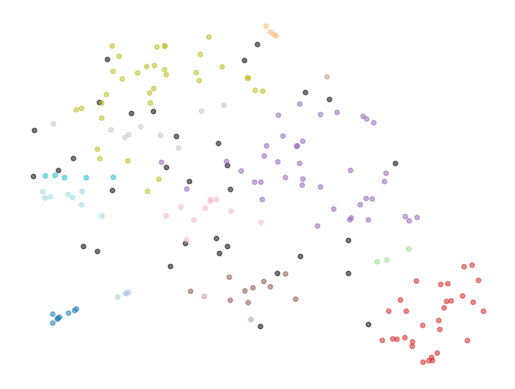

In [100]:
plt.scatter(outliers["UMAP1"], outliers["UMAP2"], c="black", s=10, alpha=0.5)
plt.scatter(to_plot["UMAP1"], to_plot["UMAP2"], c=to_plot["cluster"], cmap="tab20", s=10, alpha=0.5)
plt.axis('off')
plt.show()

In [101]:
# Convert any numerical values to strings before processing
texts = [str(text) if text is not None else "" for text in df["texte_lettre"].tolist()]
#topic_model = BERTopic(embedding_model=model, umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=True).fit(texts, embeddings)

In [128]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import nltk

# Create a stopwords list for French

# Download the stopwords from NLTK if not already downloaded
try:
    french_stopwords = set(stopwords.words('french'))
except:
    nltk.download('stopwords')
    french_stopwords = set(stopwords.words('french'))

# Add some custom stopwords specific to the letter corpus
custom_stopwords = {
    'cher', 'chère', 'monsieur', 'madame', 'ami', 'amis', 'votre', 'voici', 'merci',
    'bien', 'tout', 'tous', 'très', 'beaucoup', 'plus', 'moins', 'cette', 'cela',
    'comme', 'ainsi', 'alors', 'donc', 'avec', 'sans', 'pour', 'dans', 'sur', 'par', 
    'mon', 'ton', 'son', 'notre', 'ma', 'ta', 'sa', 'mes', 'tes', 'ses', 'nos', 'si', 'être', 'car',
    'peut', 'être', 'faire', 'dire', 'voir', 'pouvoir', 'devoir', 'savoir', 'falloir', 'vouloir', 'aller', 'où',
    'quand', 'quoi', 'comment', 'qui', 'que', 'quel', 'quelle', 'quels', 'quelles', 'lequel', 'laquelle', 'lesquels'
}

# Combine the stopwords
all_stopwords = french_stopwords.union(custom_stopwords)

In [129]:
all_stopwords

{'ai',
 'aie',
 'aient',
 'aies',
 'ainsi',
 'ait',
 'aller',
 'alors',
 'ami',
 'amis',
 'as',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'beaucoup',
 'bien',
 'c',
 'car',
 'ce',
 'cela',
 'ces',
 'cette',
 'cher',
 'chère',
 'comme',
 'comment',
 'd',
 'dans',
 'de',
 'des',
 'devoir',
 'dire',
 'donc',
 'du',
 'elle',
 'en',
 'es',
 'est',
 'et',
 'eu',
 'eue',
 'eues',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'faire',
 'falloir',
 'furent',
 'fus',
 'fusse',
 'fussent',
 'fusses',
 'fussiez',
 'fussions',
 'fut',
 'fûmes',
 'fût',
 'fûtes',
 'il',
 'ils',
 'j',
 'je',
 'l',
 'la',
 'laquelle',
 'le',
 'lequel',
 'les',
 'lesquels',
 'leur',
 'lui',
 'm',
 'ma',
 'madame

In [130]:
stopwords = list(all_stopwords)

In [131]:
stopwords

['nos',
 'eussiez',
 'fussiez',
 'serions',
 'notre',
 'tes',
 'quel',
 'fus',
 'étais',
 'si',
 'tu',
 'de',
 'quand',
 'alors',
 'ils',
 'moi',
 'cette',
 'étante',
 'y',
 'très',
 'soit',
 'lequel',
 'il',
 'ayez',
 'par',
 'moins',
 'lesquels',
 'comment',
 'vos',
 'étés',
 'étiez',
 'sont',
 'qu',
 'en',
 't',
 'seront',
 'leur',
 'sommes',
 'fut',
 'te',
 'fussent',
 'avait',
 'une',
 'aies',
 'vous',
 'des',
 'peut',
 'quoi',
 'elle',
 'soyez',
 'ami',
 'fûtes',
 'eues',
 'ton',
 'avec',
 'être',
 'monsieur',
 'lui',
 'étée',
 's',
 'fûmes',
 'tout',
 'le',
 'la',
 'es',
 'sur',
 'serait',
 'chère',
 'eussions',
 'fusses',
 'madame',
 'auraient',
 'pas',
 'est',
 'même',
 'aurions',
 'eussent',
 'pouvoir',
 'aviez',
 'votre',
 'je',
 'avais',
 'soient',
 'vouloir',
 'étées',
 'dire',
 'étions',
 'serez',
 'c',
 'tous',
 'eux',
 'serai',
 'eus',
 'voici',
 'car',
 'sa',
 'voir',
 'aurai',
 'beaucoup',
 'j',
 'ainsi',
 'soyons',
 'dans',
 'eut',
 'ses',
 'étaient',
 'êtes',
 'aura

In [132]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)
topic_model = BERTopic(vectorizer_model=vectorizer_model, embedding_model=model, umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=True).fit(texts, embeddings)

2025-03-24 20:42:28,591 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-24 20:42:28,812 - BERTopic - Dimensionality - Completed ✓
2025-03-24 20:42:28,812 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-24 20:42:28,815 - BERTopic - Cluster - Completed ✓
2025-03-24 20:42:28,817 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-24 20:42:28,914 - BERTopic - Representation - Completed ✓


In [133]:
texts

["Paris, le 14 Juin 1916\n                     .\n\nMon \n                     Cher \n                     cher \n                  \n                  Marcel,\n\nJe viens\n                    de recevoir ta lettre du 10 courant meretournant un chèque de\n                        \n                  40.000 \n                  40 000 \n               \n               \n                  Fr.\n                  francs\n                signé par toi\n                    que je ferai encaisser et\n                    dont je ferai verser la contrevaleur au Crédit\n                            Industriel.\n\nJ'ai\n                    également retiré de ta lettre ton compte de\n                        liquidation chez\n                        l'Industriel au 31 \n                     Mai \n                     mai \n                  \n               qui\n                    n'apporte en somme aucunélément nouveau. Quant à la lettre du\n                        Crédit\n                        I

In [134]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,38,-1_marcel_aussi_etc_dit,"[marcel, aussi, etc, dit, peu, dont, fait, sai...",[Mon cher Lionel\n\nJe t'ai bien écrit tout de...
1,0,101,0_fait_lettre_peu_encore,"[fait, lettre, peu, encore, avoir, aussi, jama...",[Cher Reynaldo\n\nJe vous remercie de tout coe...
2,1,13,1_fait_aussi_etc_depuis,"[fait, aussi, etc, depuis, alexandre, encore, ...","[Bonjour, Metmata\n\nBunibuls comme rien n’est..."
3,2,11,2_robert_figaro_robert dreyfus_dreyfus,"[robert, figaro, robert dreyfus, dreyfus, drey...",[Je cherche à me rappeler tout ce que je sais ...
4,3,9,3_guerre_avant_encore_depuis,"[guerre, avant, encore, depuis, contre, cessé,...","[9 janvier 1915\n\nMadame,\n\nJe ne savais rie..."
5,4,8,4_seine_boulevard_conseil_conseil revision,"[seine, boulevard, conseil, conseil revision, ...",[24 - 2 - 08\n\nMonsieurRobert\n ...
6,5,6,5_000_30 000_écrire_grand,"[000, 30 000, écrire, grand, sais, mlle, reçu,...",[Mon cher Robert\n\nPermets moi\n ...
7,6,6,6_recevoir_sincèrement_marcel_ceci,"[recevoir, sincèrement, marcel, ceci, nouvelle...",[Paris le 3 janvier\n 1918\...
8,7,5,7_titres_industriel_rente_valeurs,"[titres, industriel, rente, valeurs, française...","[Paris, le 14 Juin 1916\n ..."
9,8,4,8_proust_soussigné_bize_quotidiennes,"[proust, soussigné, bize, quotidiennes, dr biz...","[Je\n soussigné, \n ..."


In [135]:
topic_model.get_topic(0)

[('fait', np.float64(0.010454844485209993)),
 ('lettre', np.float64(0.009109233289516518)),
 ('peu', np.float64(0.007924886472139358)),
 ('encore', np.float64(0.007703970955909379)),
 ('avoir', np.float64(0.007336362441221503)),
 ('aussi', np.float64(0.007218470587529482)),
 ('jamais', np.float64(0.006962483645815633)),
 ('trop', np.float64(0.006686539680869224)),
 ('fois', np.float64(0.006565874841165527)),
 ('chez', np.float64(0.00645836307632349))]

In [138]:
topic_model.find_topics("dreyfus")

([4, 8, 1, 3, 2],
 [np.float32(0.34683457),
  np.float32(0.1628772),
  np.float32(0.16126797),
  np.float32(0.1308817),
  np.float32(0.115334064)])

In [139]:
topic_model.get_topic(4)

[('seine', np.float64(0.09708919423921744)),
 ('boulevard', np.float64(0.08638684367379089)),
 ('conseil', np.float64(0.07768211527745607)),
 ('conseil revision', np.float64(0.07425373361031377)),
 ('revision', np.float64(0.07281689567941309)),
 ('paris', np.float64(0.0572842982324212)),
 ('154', np.float64(0.053518150457620386)),
 ('malesherbes', np.float64(0.053518150457620386)),
 ('dreyfus 154', np.float64(0.053518150457620386)),
 ('valentin', np.float64(0.053518150457620386))]

In [140]:
topic_model.visualize_topics()

In [141]:
fig = topic_model.visualize_documents(dfUMAP['texte_lettre'].to_list(), reduced_embeddings=reduced_embeddings, width=800, height=800, hide_annotations=True)
fig.show()

In [144]:
fig = topic_model.visualize_barchart(top_n_topics=10, width=800, height=800)
fig.show()